In [127]:
import base64
from random import sample
import tensorflow as tf
from tensorflow import keras
import os
import json
import matplotlib.pyplot as plt
import base64
import numpy as np
import csv
from glob import glob


dataset_path = os.getcwd()
dataset_path = os.path.join(dataset_path, 'dataset')

train_json_paths = sorted(glob(os.path.join(dataset_path, 'train', '*.json')))
test_json_paths = sorted(glob(os.path.join(dataset_path, 'test', '*.json')))

In [125]:
len(train_json_paths), len(test_json_paths)

(62622, 20874)

In [113]:
classes = []
labels = []
with open(dataset_path / 'class_id_info.csv') as class_id_info:
    class_to_id = csv.reader(class_id_info)
    for row in class_id_info:
        c, l = row.strip().split(',')
        classes.append(c)
        labels.append(l)

classes = tf.constant(classes[1:])
labels = tf.constant(list(map(int, labels[1:])))


In [115]:
classes.numpy(), labels.numpy()

(array([b'01_ulcer', b'02_mass', b'04_lymph', b'05_bleeding'], dtype=object),
 array([1, 2, 3, 4], dtype=int32))

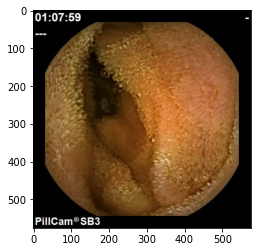

In [103]:
with open(train_json_paths[0], 'r') as sample_json:
    sample_json = json.load(sample_json)

image_data = sample_json['imageData']
image = base64.b64decode(image_data)
image = tf.image.decode_image(image, channels=3)
image = tf.cast(image, dtype=tf.float32)

plt.imshow(image / 255.)

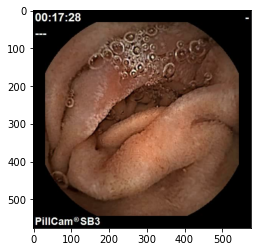

In [65]:
with open(train_json_paths[1], 'r') as sample_json:
    sample_json = json.load(sample_json)

image_data = sample_json['imageData']
image_data = tf.strings.regex_replace(image_data, '[/]', '_')
image_data = tf.strings.regex_replace(image_data, '[+]', '-')
image = tf.io.decode_base64(image_data)

image = tf.image.decode_image(image, channels=3)
image = tf.cast(image, dtype=tf.float32) / 255.

plt.imshow(image)

In [89]:
print(sample_json.keys())
print(sample_json['shapes'][0]['label'])
print(sample_json['shapes'][0]['points'])

points = tf.constant(sample_json['shapes'][0]['points'])

print(points)

dict_keys(['file_name', 'shapes', 'imageData', 'imageHeight', 'imageWidth'])
01_ulcer
[[157.9928057553957, 144.47482014388478], [281.0143884892086, 144.47482014388478], [281.0143884892086, 273.25179856115096], [157.9928057553957, 273.25179856115096]]
tf.Tensor(
[[157.99281 144.47482]
 [281.01437 144.47482]
 [281.01437 273.2518 ]
 [157.99281 273.2518 ]], shape=(4, 2), dtype=float32)


tf.Tensor(144.47482, shape=(), dtype=float32) tf.Tensor(157.99281, shape=(), dtype=float32) tf.Tensor(128.77698, shape=(), dtype=float32) tf.Tensor(123.02156, shape=(), dtype=float32)


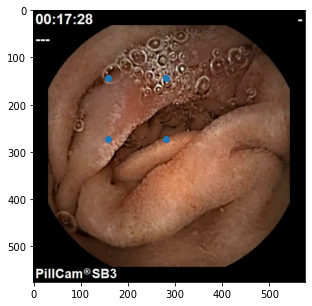

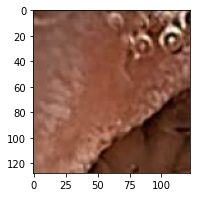

In [90]:


image_cropped = tf.image.crop_to_bounding_box(image[0], *points_to_bounding_box(points))
plt.figure(figsize=(5,5))
plt.imshow(image[0])
plt.scatter(points[:, 0], points[:, 1])

plt.figure(figsize=(3,3))
plt.imshow(image_cropped)

In [120]:
def parse_json_to_dict(json_path):
    with open(json_path, 'r') as json_file:
        dict_data = json.load(json_file)
    return dict_data

In [121]:
def load_data(dict_data):
    base64_image = dict_data['imageData']
    base64_image = tf.strings.regex_replace(base64_image, '[/]', '_')
    base64_image = tf.strings.regex_replace(base64_image, '[+]', '-')
    
    image = tf.io.decode_base64(base64_image)
    image = tf.image.decode_image(image, channels=3)
    image = tf.cast(image, dtype=tf.float32) / 255.

    box_points = dict_data['shapes'][0]['points']
    box_points = points_to_bounding_box(box_points)

    _class = dict_data['shapes'][0]['label']
    _label = labels[classes == _class][0]
    return image, (_label , box_points)

def points_to_bounding_box(points):
    offset_width, offset_height = points[0]
    box_width, box_height = points[2] - points[0]
    return tf.cast([offset_height, offset_width, box_height, box_width], tf.int32)

In [122]:
def create_dataset(tf_filepaths, autotune=tf.data.AUTOTUNE, shuffle_buffer_size=None, batch_size=32, cache=False):
    filepath_dataset = tf.data.Dataset.from_tensor_slices(tf_filepaths)
    dict_dataset = filepath_dataset.map(parse_json_to_dict, num_parallel_calls=autotune)
    dataset = dict_dataset.map(load_data, num_parallel_calls=autotune)
    return dataset.shuffle(shuffle_buffer_size).batch(batch_size).prefetch(autotune)


In [123]:
dataset = create_dataset(train_json_paths,cache=True)

ValueError: Attempt to convert a value (PosixPath('/Users/hwijin/Desktop/Code/ml/병변검출/dataset/train/train_100000.json')) with an unsupported type (<class 'pathlib.PosixPath'>) to a Tensor.